In [1]:
# Import Python SQL toolkit and Object Relational Mapper, and other dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import matplotlib
#matplotlib.use('nbagg') TO DELETE
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np

In [2]:
#Create engine for "hawaii.sqlite" db file
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [4]:
engine.execute('SELECT * FROM stations LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [5]:
# Create the inspector and connect it to the engine
# Also get names of tables in the db
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [6]:
# Reflect Database into ORM classes (Station and Measurement)
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.stations
Measurement = Base.classes.measurements

In [7]:
session = Session(engine)

## Precipitation Analysis

In [8]:
#Design a query to retrieve the last 12 months of precipitation data.

# First, get the most recent date
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
    
print(last_date)

('2017-08-23',)


In [9]:
# Most recent date in the table is 2017-08-23, so need to get previous 12 months (365 days)
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)  
print(query_date)


2016-08-23


In [10]:
# Query for last 12 months of precipitation data
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).all()
    

In [11]:
# Create dataframe from the query data (set index to 'date')
prcp_df = pd.DataFrame(prcp_data)
prcp_df.set_index('date')
prcp_df.head()



,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


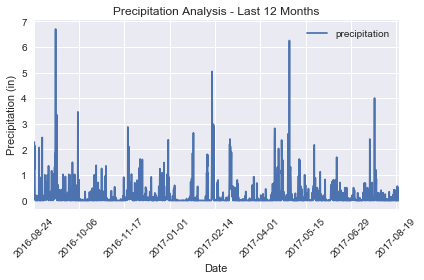

In [12]:
# Plot the results in a Matplotlib bar chart (TO FINISH)

prcp_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Precipitation Analysis - Last 12 Months")
plt.legend(["precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# Use Pandas to print the summary statistics for the precipitation data
## using describe command

prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [14]:
#Design a query to calculate the total number of stations
#num_stations = session.query(func.count(Station.station)).all() 
num_stations = session.query(Station).count()
print("There are {} total stations.".format(num_stations))

There are 9 total stations.


In [15]:
# Design a query to find the most active stations (highest number of observations).
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

## List the stations and observation counts in descending order
print("Stations and their respective observation counts (descending):")
for station, tobs_count in active_stations:
    print("Station: " + str(station) + ", Observation Count:" + str(tobs_count))

## Which station has the highest number of observations?
most_active_station = active_stations[0][0]
print()
print("The most active station was {}.".format(most_active_station))

    


Stations and their respective observation counts (descending):
Station: USC00519281, Observation Count:2772
Station: USC00513117, Observation Count:2696
Station: USC00519397, Observation Count:2685
Station: USC00519523, Observation Count:2572
Station: USC00516128, Observation Count:2484
Station: USC00514830, Observation Count:1937
Station: USC00511918, Observation Count:1932
Station: USC00517948, Observation Count:683
Station: USC00518838, Observation Count:342

The most active station was USC00519281.


In [16]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
## Filter by the station with the highest number of observations.
tobs_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date > query_date, Measurement.station == most_active_station).\
    order_by(Measurement.date).all()

    

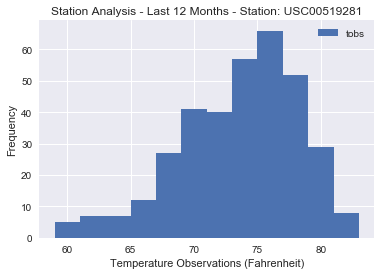

In [17]:
## Plot the results as a histogram with bins=12.
# df_station = pd.DataFrame(station_data, columns=['tobs', 'Frequency'])
# df_station.set_index('tobs', inplace=True)
# df_station.plot.hist(bins=12, histtype='bar', align='mid', orientation='vertical', color="Blue")
# plt.show()

## Create the df
tobs_df = pd.DataFrame(tobs_data)


## PLot the results (histogram, bins=12)
plt.hist(tobs_df['tobs'], 12)
plt.xlabel("Temperature Observations (Fahrenheit)")
plt.ylabel("Frequency")
plt.title("Station Analysis - Last 12 Months - Station: " + most_active_station)
plt.legend(["tobs"])
plt.show()


## Temperature Analysis

In [18]:
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d
# and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
        return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
               filter(Measurement.date >= start_date, Measurement.date <= end_date).all()
        

In [19]:
# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year 
#(i.e. use "2017-01-01" if your trip start date was "2018-01-01")

trip_start = dt.date(2018, 7, 3)
trip_end = dt.date(2018, 7, 10)
prev_year = dt.timedelta(365)
prev_year_temp_results = (calc_temps(trip_start - prev_year, trip_end - prev_year))
print("The temperature recordings from the prior year matching our trip are:")
print("Min: " + str(prev_year_temp_results[0][0]) + ", Avg: " + str(prev_year_temp_results[0][1]) + ", Max: " + str(prev_year_temp_results[0][2]))  

The temperature recordings from the prior year matching our trip are:
Min: 69, Avg: 77.65853658536585, Max: 82


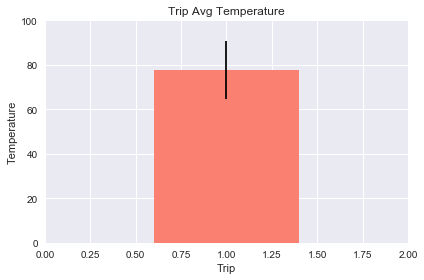

In [29]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
## Use the average temperature as the bar height.
## Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

### Set the variables for peak-to-peal, min, avg, max
peak_to_peak = prev_year_temp_results[0][2] - prev_year_temp_results[0][0]
min_temp = prev_year_temp_results[0][0]
avg_temp = prev_year_temp_results[0][1]
max_temp = prev_year_temp_results[0][2]

### Create bar chart
fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avg_temp, color= 'salmon', yerr=peak_to_peak)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Avg Temperature")

plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()

